<a href="https://colab.research.google.com/github/debabratoRoy/Gravitational-Wave-Open-Data-Workshop/blob/main/Intro_to_GWpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
pip install -q  gwpy

In [29]:
import gwpy
from gwosc.datasets import event_gps

In [30]:
from gwpy.timeseries import TimeSeries

In [31]:
import matplotlib.pyplot as plt
from scipy.signal import get_window

## Finding Open Data

Let's read some open data. Let's try to get some for GW190412, the first detection of a gravitational-wave signal from a significantly unequal-mass BBH (binary black hole system)

We can use `TimeSeries.fetch_open_data` method to directly download data from `https://www.gw-openscience.org`.

We first need the GPS times.

In [32]:
gps = event_gps('GW190412')
gps

1239082262.1

Now we can build a `[start,end)` GPS segment to 10 seconds around this time, using integers for convenience:

In [33]:
segment = ( int(gps) - 5 , int(gps) + 5 )
segment

(1239082257, 1239082267)

Now query for the full data. For this example we choose to retrieve data for the LIGO-Livingston interferometer, using the identifier `L1`. We could have chosen any of

* `G1` - GEO600
* `H1` - LIGO-Hanford
* `L1` - LIGO-Livingston
* `V1` - (Advanced) Virgo
* `K1` - KAGRA

In [34]:
ldata = TimeSeries.fetch_open_data('L1', *segment, verbose=True)
ldata

Fetched 1 URLs from gwosc.org for [1239082257 .. 1239082267))
Reading data... [Done]


<TimeSeries([-8.42597565e-19, -8.52437103e-19, -8.60738804e-19,
             ...,  1.38850270e-19,  1.37760541e-19,
              1.38094202e-19]
            unit=Unit(dimensionless),
            t0=<Quantity 1.23908226e+09 s>,
            dt=<Quantity 0.00024414 s>,
            name='Strain',
            channel=None)>

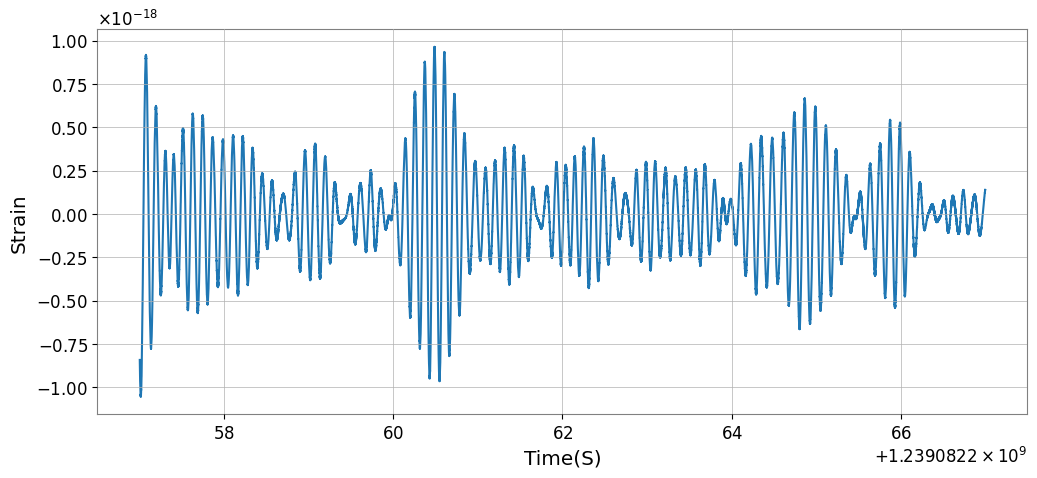

In [35]:
plt.figure(figsize=(12,5))
plt.plot(ldata.times,ldata)
plt.xlabel('Time(S)')
plt.ylabel('Strain')
plt.show()

## Handling data in the frequency domain using the Fourier transform

We can calculate the Fourier transform of our `TimeSeries` using `fft()` method:

In [36]:
fft = ldata.fft()
fft

<FrequencySeries([-1.45894410e-21+0.00000000e+00j,
                  -2.91834926e-21-4.52905657e-23j,
                  -2.91973330e-21-9.06202944e-23j, ...,
                  -2.38723982e-23+4.67871178e-26j,
                  -2.38345362e-23+1.80394058e-26j,
                  -2.38457175e-23+0.00000000e+00j]
                 unit=Unit(dimensionless),
                 f0=<Quantity 0. Hz>,
                 df=<Quantity 0.1 Hz>,
                 epoch=<Time object: scale='utc' format='gps' value=1239082257.0>,
                 name='Strain',
                 channel=None)>

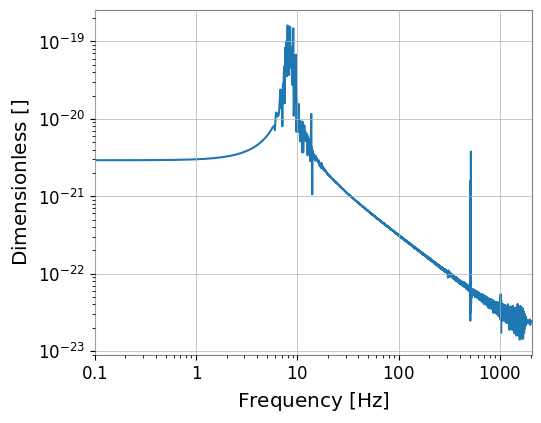

In [37]:
plot = fft.abs().plot(xscale='log',yscale='log')
plot.show(warn=False)

In [38]:
window = get_window('hann', ldata.size)
lwin = ldata * window

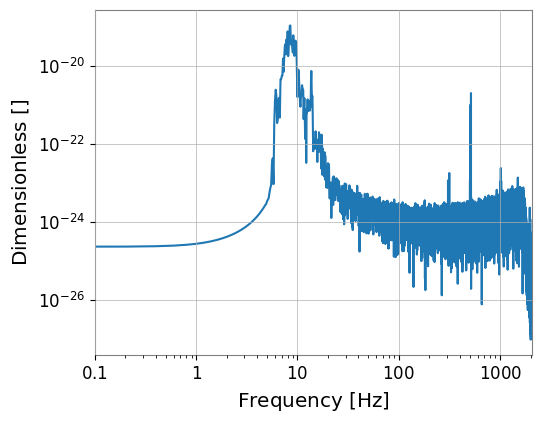

In [39]:
fftamp = lwin.fft().abs()
plot = fftamp.plot(xscale="log",yscale="log")
plot.show(warn=False)

### Estimating the power spectral density

There is dense fluctuation in the above plot for frequencies larger than 10Hz. This is the intrinsic noise in the estimate of the spectral content of the single FFT.

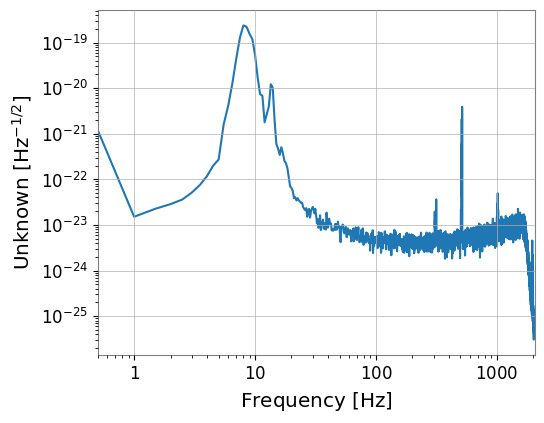

In [40]:
asd = ldata.asd(fftlength=2, method="median")
plot = asd.plot()
plot.show(warn=False)

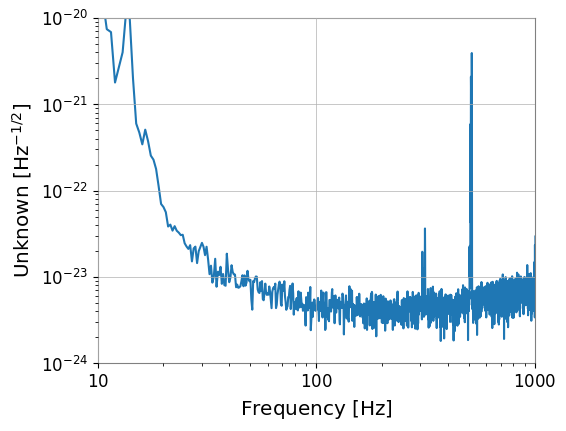

In [41]:
ax = plot.gca()
ax.set(xlim=(10,1000), ylim=(1e-24,1e-20))
plot

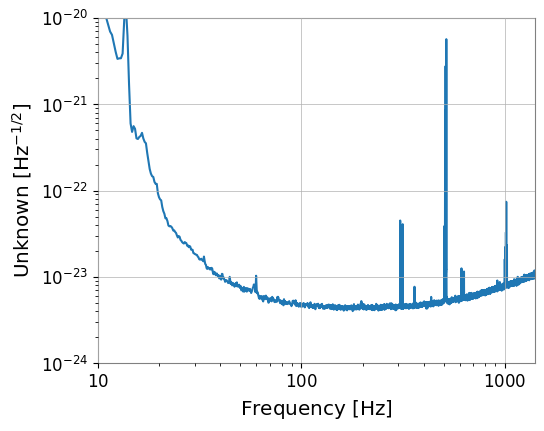

In [42]:
ldata2 = TimeSeries.fetch_open_data('L1', int(gps) - 512, int(gps) + 512, cache=True)
lasd2 = ldata2.asd(fftlength=4, method="median")
plot = lasd2.plot()
ax = plot.gca()
ax.set(xlim=(10,1400), ylim=(1e-24,1e-20))
plot.show(warn=False)

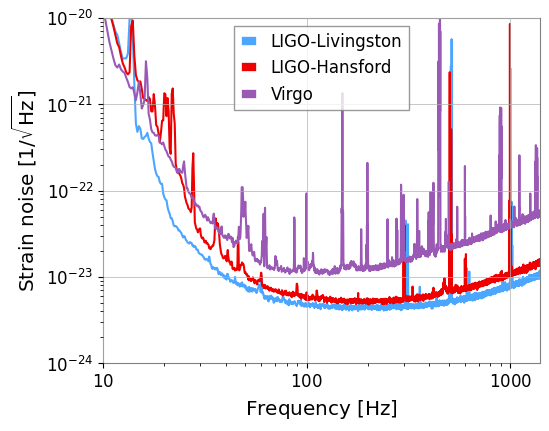

In [43]:
# get Hanford data

hdata2 = TimeSeries.fetch_open_data('H1', int(gps)-512, int(gps)+512, cache=True)
hasd2 = hdata2.asd(fftlength=4,method="median")

# get Virgo data

vdata2 = TimeSeries.fetch_open_data('V1', int(gps)-512, int(gps)+512, cache=True)
vasd2 = vdata2.asd(fftlength=4,method="median")

# and plot using the standard colors

ax.plot(hasd2, label='LIGO-Hansford', color='gwpy:ligo-hanford')
ax.plot(vasd2, label='Virgo', color='gwpy:virgo')

# update the Livingston linne to use standard color, and have a label

lline = ax.lines[0]
lline.set_color('gwpy:ligo-livingston')
lline.set_label('LIGO-Livingston')

ax.set_ylabel(r'Strain noise [$1 / \sqrt{\mathrm{Hz}}$]')
ax.legend()

plot

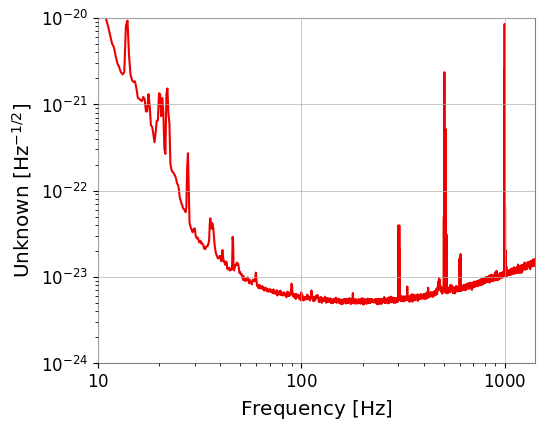

In [44]:
ax = hasd2.plot().gca()
ax.set(xlim=(10,1400),ylim=(1e-24,1e-20))
ax.lines[0].set_color('gwpy:ligo-hanford')
